# Analysis of aggregate results


In [1]:
# Imports
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import pandas as pd
import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from scipy.stats import pearsonr
import pingouin as pg

from lib.analysis_tools import plot_boxes_grade_cats

In [2]:
abt_spad = pd.read_csv('data/han_spad_abt.csv')
abt_oopd = pd.read_csv('data/han_oopd_abt.csv')
abt_oop = pd.read_csv('data/hu_oop_abt.csv')

abt = pd.concat([abt_spad.copy(), abt_oopd.copy(), abt_oop.copy()]).reset_index(drop = True).copy()
abt

,assignment,file,kloc,submission_date,grade,subgrade_datatypes,subgrade_methods,subgrade_control_structures,subgrade_events,subgrade_coding_standard,...,checkstyle_HideUtilityClassConstructor,checkstyle_InterfaceIsType,checkstyle_LambdaBodyLength,checkstyle_NestedTryDepth,pmd_AvoidDecimalLiteralsInBigDecimalConstructor,pmd_AvoidLosingExceptionInformation,pmd_BrokenNullCheck,pmd_MisplacedNullCheck,pmd_PreserveStackTrace,pmd_UselessOperationOnImmutable
0,HAN SPAD,aGFzaDg1NzE4NjQ2OTU5MDg3NDcyNTk=,0.905,2019-10-31,8.500000,10.0,8.0,10.0,10.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HAN SPAD,aGFzaC0yNzM0NTA5Nzk1MjQwNjY0Mjk5,0.994,2019-11-01,7.000000,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HAN SPAD,aGFzaDE2Mzc4OTM3Nzk1MTg4NDY4MjY=,0.492,2019-11-01,7.400000,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HAN SPAD,aGFzaC0zNzAwMjU4OTk1NTE5MzQ2ODQy,0.448,2019-10-30,8.200000,8.0,8.0,10.0,6.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HAN SPAD,aGFzaDgzMTY2MjQwNjA2Nzk3MzA4ODU=,0.468,2019-11-01,7.900000,8.0,8.0,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,HU OOP,a81277,1.365,NaN,9.411765,NaN,NaN,NaN,NaN,NaN,...,8.791209,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1380,HU OOP,a242532,1.739,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,...,7.475561,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1381,HU OOP,a92019,1.102,NaN,5.882353,NaN,NaN,NaN,NaN,NaN,...,13.611615,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1382,HU OOP,a92317,1.477,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,10.155721,NaN,0.0,0.677048,0.0,0.0,0.0,0.0,0.000000,0.0


# Cleanup

In [3]:
print(f"Number of assignments total: {abt['grade'].count()} ")
print(f"Number of assignments with a grade of zero: {abt[abt['grade'] < 1]['grade'].count()}")
print(f"Number of assignments where no errors could be detected: {abt[abt['errors_total'] == 0]['grade'].count()}")
print(f"Number of assignments with a failing grade: {abt[abt['grade'] < 5.5]['grade'].count()} ")
abt_clean = abt[(abt['grade'] >= 1) & (abt['errors_total'] > 0)].reset_index(drop = True).copy()

print(f"Number of assignments after cleanup: {abt_clean['grade'].count()}")

# Drop columns for subgrades
abt_clean = abt_clean.drop([x for x in abt_clean.columns if x.startswith('subgrade')],axis = 1)

# NaNs are metrics that were not found for a specific assignment. Just set them to 0
abt_clean = abt_clean.fillna(0)

# Failing grades are distributed unevenly because they contain knockout values.
# Set all of them to 4.0 if they're lower than 4.0
abt_clean.grade = abt_clean['grade'].map(lambda x : 5.0 if x < 5.0 else x)


# HU OOP has either pass or fail. Fail has been mapped to 4.0 above.
# Here map pass to 7.5 (average between 5.5 and 10)
abt_clean.loc[abt_clean['assignment'] == 'HU OOP', 'grade'] = abt_clean[abt_clean['assignment'] == 
        'HU OOP']['grade'].apply(lambda x : 7.5 if x > 5.5 else x)
abt_clean[abt_clean['assignment'] == 'HU OOP']['grade']
abt_oop['grade'] = abt_oop['grade'].apply(lambda x : 7.0 if x >=5.5 else 5.0)


Number of assignments total: 1384 
Number of assignments with a grade of zero: 54
Number of assignments where no errors could be detected: 41
Number of assignments with a failing grade: 180 
Number of assignments after cleanup: 1291


In [4]:



# Only retain columns for categories, clusters and totals.
abt_final = abt_clean[['grade', 
                       'errors_count',
                       'errors_total'] + [x for x in abt_clean.columns if x.startswith('cluster_') ] +
                       ['pmd_count',
                       'pmd_total'] + [x for x in abt_clean.columns if x.startswith('pmd_cat_')] +
                       ['checkstyle_count',
                        'checkstyle_total'] + [x for x in abt_clean.columns if x.startswith('checkstyle_cat_')]].reset_index(drop = True).copy()
# Additionally, create columns for the categories teachers were
# questioned about.
abt_final['cat_Code style'] = abt_final['pmd_cat_Code style'].copy()
abt_final['cat_Design'] = abt_final['pmd_cat_Design'] + abt_final['checkstyle_cat_Class Design']
abt_final['cat_ErrorProne'] = abt_final['pmd_cat_ErrorProne'].copy()
abt_final['cat_SizeViolations'] = abt_final['checkstyle_cat_SizeViolations'].copy()


In [5]:
# When graphing box plots, normalize values between 0 and 1
must_normalize = False

if must_normalize:
    for x in abt_final.columns:
        if x == 'grade':
          continue
        abt_final[x] = abt_final[x] / abt_final[x].max()

abt_final

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,...,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
0,8.5,34.254144,537.016575,121.546961,6.629834,67.403315,341.436464,0.000000,19.889503,155.801105,...,0.000000,169.060773,198.895028,4.419890,5.524862,3.314917,104.972376,204.419890,1.104972,3.314917
1,7.0,47.283702,588.531187,182.092555,9.054326,22.132797,375.251509,0.000000,32.193159,181.086519,...,0.000000,132.796781,264.587525,7.042254,3.018109,0.000000,136.820926,152.917505,9.054326,0.000000
2,7.4,56.910569,575.203252,178.861789,10.162602,71.138211,315.040650,0.000000,34.552846,217.479675,...,6.097561,176.829268,162.601626,8.130081,4.065041,0.000000,168.699187,213.414634,0.000000,0.000000
3,8.2,98.214286,870.535714,381.696429,22.321429,55.803571,372.767857,37.946429,55.803571,386.160714,...,0.000000,116.071429,343.750000,8.928571,11.160714,4.464286,314.732143,145.089286,4.464286,4.464286
4,7.9,49.145299,722.222222,243.589744,10.683761,115.384615,350.427350,2.136752,29.914530,286.324786,...,0.000000,151.709402,271.367521,8.547009,4.273504,0.000000,262.820513,173.076923,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,7.5,20.860495,506.301608,269.013472,0.434594,76.053890,160.799652,0.000000,13.037810,327.683616,...,0.434594,76.053890,99.521947,1.303781,0.869187,0.434594,205.562799,139.069970,6.518905,0.434594
1287,7.5,32.234432,528.937729,280.586081,0.000000,69.597070,177.289377,1.465201,22.710623,336.996337,...,0.000000,93.772894,96.703297,0.732601,0.732601,0.000000,204.395604,161.172161,7.326007,0.000000
1288,7.5,23.576768,541.115584,262.794710,0.000000,70.730305,207.590569,0.000000,14.376078,328.924669,...,0.000000,105.232892,102.932720,2.875216,1.150086,0.000000,189.189189,194.939620,3.450259,0.000000
1289,7.5,29.038113,467.332123,221.415608,0.000000,61.705989,184.210526,0.000000,19.056261,283.121597,...,0.000000,98.003630,83.484574,2.722323,0.000000,0.000000,159.709619,176.950998,1.814882,0.000000


# Distribution of grades

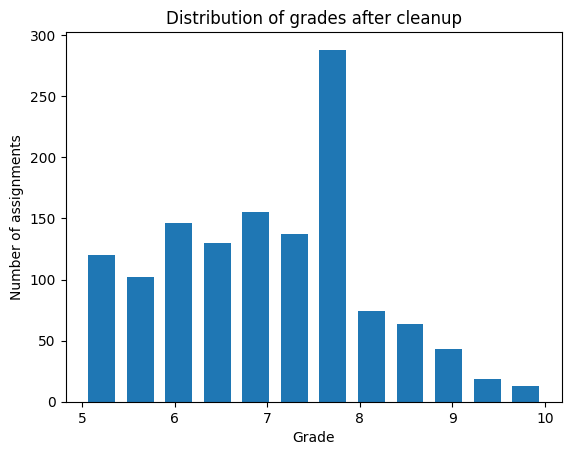

In [6]:
ax = abt_final['grade'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of grades after cleanup')
plt.show()

## Distribution of failing grades before cleanup

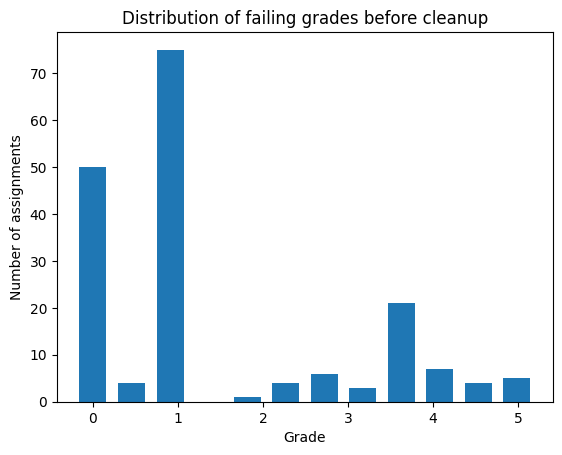

In [7]:
ax = abt[abt['grade'] < 5.5]['grade'].hist(
    bins = 12, 
    rwidth = 0.7, 
    align="left")
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of failing grades before cleanup')
plt.show()

# Correlations

## Correlations for all grades

In [8]:
corr = abt_final.corr(method='pearson') # Spearman can to correct for non-normal distribution. Effect is very small, however.
corr.style.background_gradient(cmap='coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.319201,-0.230109,0.056108,-0.177730,-0.235909,-0.247561,0.007108,-0.318433,0.019685,0.082130,0.013361,-0.016111,-0.015377,-0.307301,-0.265824,-0.034864,-0.216527,-0.218327,-0.205041,-0.160474,-0.043844,0.013361,-0.196788,-0.015377,-0.043844
errors_count,-0.319201,1.000000,0.546122,0.296065,0.352737,0.537936,0.419813,0.277715,0.985332,0.323062,-0.148138,0.422411,-0.031529,0.162196,0.977782,0.486931,0.092152,0.580704,0.316552,0.774102,0.295172,0.201237,0.422411,0.501778,0.162196,0.201237
errors_total,-0.230109,0.546122,1.000000,0.519771,0.459496,0.388051,0.919138,0.213725,0.511223,0.469633,0.010075,0.490858,0.185559,0.120796,0.567018,0.939080,0.017656,0.624561,0.838305,0.416860,0.413388,0.335538,0.490858,0.615993,0.120796,0.335538
cluster_Best practices,0.056108,0.296065,0.519771,1.000000,0.035825,0.326153,0.182375,0.185831,0.300030,0.926629,0.408849,0.891808,0.328703,0.213221,0.279282,0.222398,-0.024853,0.504395,0.068756,0.246828,0.018899,0.114017,0.891808,0.559668,0.213221,0.114017
cluster_Complexity,-0.177730,0.352737,0.459496,0.035825,1.000000,0.063953,0.473338,0.151238,0.290890,-0.043027,-0.241852,-0.051001,0.081846,0.139501,0.414516,0.532263,0.049325,0.256710,0.487545,0.158153,0.801143,0.593632,-0.051001,0.255127,0.139501,0.593632
cluster_Incomplete code,-0.235909,0.537936,0.388051,0.326153,0.063953,1.000000,0.145628,0.107910,0.537080,0.531932,0.044531,0.479630,0.454251,-0.002632,0.517344,0.228276,0.018662,0.397234,0.100508,0.505873,0.084659,0.062625,0.479630,0.508708,-0.002632,0.062625
cluster_Reusability and extendibility,-0.247561,0.419813,0.919138,0.182375,0.473338,0.145628,1.000000,0.121750,0.379669,0.112338,-0.145096,0.161672,0.009379,0.058708,0.452233,0.987455,0.024145,0.470849,0.953571,0.301557,0.431221,0.315585,0.161672,0.419005,0.058708,0.315585
cluster_Side effects,0.007108,0.277715,0.213725,0.185831,0.151238,0.107910,0.121750,1.000000,0.265811,0.189800,0.162407,0.216644,-0.056647,0.011786,0.281165,0.165890,0.011218,0.265846,0.085150,0.177046,0.142632,0.146498,0.216644,0.215034,0.011786,0.146498
pmd_count,-0.318433,0.985332,0.511223,0.300030,0.290890,0.537080,0.379669,0.265811,1.000000,0.342644,-0.114426,0.431576,-0.024708,0.186325,0.927668,0.440154,0.081768,0.567908,0.270360,0.759723,0.226094,0.136921,0.431576,0.492851,0.186325,0.136921
pmd_total,0.019685,0.323062,0.469633,0.926629,-0.043027,0.531932,0.112338,0.189800,0.342644,1.000000,0.468242,0.901356,0.534367,0.150734,0.286009,0.137584,-0.015891,0.478362,-0.019314,0.290242,-0.055681,0.036614,0.901356,0.608201,0.150734,0.036614


In [9]:
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final['grade'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.95)
    pearson_vals.append({
        'Metric' : cat,
        'Average value': float(round(abt_final[cat].mean() * 100)) / 100,
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .95 low' : confidence_interval[0],
        'Confidence interval .95 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('../data/all_pearson_vals.xlsx')
pd.DataFrame(pearson_vals)

,Metric,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .95 low,Confidence interval .95 high
0,errors_count,48.12,27.27,-0.32,5.765807e-32,0.00000,-0.367361,-0.269333
1,errors_total,573.09,236.60,-0.23,5.640075e-17,0.00000,-0.281137,-0.177783
2,cluster_Best practices,191.74,73.64,0.06,4.383909e-02,0.04383,0.001555,0.110328
3,cluster_Complexity,11.07,11.57,-0.18,1.267642e-10,0.00000,-0.230057,-0.124378
4,cluster_Incomplete code,77.16,38.26,-0.24,8.725144e-18,0.00000,-0.286776,-0.183715
5,cluster_Reusability and extendibility,289.85,192.07,-0.25,1.760505e-19,0.00000,-0.298093,-0.195645
6,cluster_Side effects,3.28,7.62,0.01,7.985977e-01,0.79859,-0.047468,0.061642
7,pmd_count,28.63,15.31,-0.32,8.212034e-32,0.00000,-0.366622,-0.268540
8,pmd_total,240.46,82.10,0.02,4.797788e-01,0.47977,-0.034911,0.074163
9,pmd_cat_Best practices,17.39,16.16,0.08,3.145840e-03,0.00314,0.027696,0.136079


## Correlations for passing grades only

In [10]:
corr = abt_final[abt_final['grade'] >= 5.5].corr()
corr.style.background_gradient(cmap='coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.339758,-0.255937,0.016053,-0.210631,-0.239302,-0.264756,-0.012057,-0.341658,-0.015469,0.100855,-0.021700,-0.034956,-0.047789,-0.323695,-0.285849,-0.010014,-0.240073,-0.231911,-0.207117,-0.179849,-0.056417,-0.021700,-0.223878,-0.047789,-0.056417
errors_count,-0.339758,1.000000,0.556558,0.319137,0.348100,0.558952,0.424288,0.296774,0.985358,0.345716,-0.139522,0.438792,-0.019235,0.175428,0.977663,0.496865,0.051890,0.578755,0.325742,0.769840,0.290901,0.210360,0.438792,0.504042,0.175428,0.210360
errors_total,-0.255937,0.556558,1.000000,0.554999,0.457976,0.389963,0.917518,0.213147,0.523764,0.506181,0.029539,0.526428,0.190475,0.129997,0.574506,0.938708,-0.010565,0.633062,0.835136,0.417016,0.412319,0.324649,0.526428,0.624231,0.129997,0.324649
cluster_Best practices,0.016053,0.319137,0.554999,1.000000,0.055212,0.337347,0.220376,0.211991,0.321124,0.927514,0.411881,0.893636,0.320386,0.209481,0.303800,0.262542,-0.018152,0.513058,0.106834,0.265321,0.033606,0.138792,0.893636,0.563115,0.209481,0.138792
cluster_Complexity,-0.210631,0.348100,0.457976,0.055212,1.000000,0.076783,0.469269,0.144185,0.286210,-0.026057,-0.240997,-0.036381,0.092036,0.149621,0.410335,0.532978,0.002835,0.269920,0.484612,0.150246,0.832198,0.580393,-0.036381,0.269885,0.149621,0.580393
cluster_Incomplete code,-0.239302,0.558952,0.389963,0.337347,0.076783,1.000000,0.142107,0.128978,0.558868,0.541137,0.055229,0.489231,0.450915,0.000774,0.536480,0.228666,0.016261,0.394553,0.096828,0.526245,0.107320,0.069145,0.489231,0.503534,0.000774,0.069145
cluster_Reusability and extendibility,-0.264756,0.424288,0.917518,0.220376,0.469269,0.142107,1.000000,0.108349,0.386698,0.151163,-0.128768,0.199887,0.017095,0.070449,0.453493,0.986495,-0.009132,0.482510,0.951545,0.293939,0.424286,0.296200,0.199887,0.431639,0.070449,0.296200
cluster_Side effects,-0.012057,0.296774,0.213147,0.211991,0.144185,0.128978,0.108349,1.000000,0.285319,0.216245,0.173321,0.245160,-0.054347,0.012107,0.298909,0.156773,-0.010577,0.280400,0.066480,0.185856,0.153103,0.153014,0.245160,0.228685,0.012107,0.153014
pmd_count,-0.341658,0.985358,0.523764,0.321124,0.286210,0.558868,0.386698,0.285319,1.000000,0.363764,-0.107811,0.446588,-0.012059,0.198101,0.927513,0.452233,0.044088,0.566750,0.281496,0.756403,0.222220,0.143659,0.446588,0.495922,0.198101,0.143659
pmd_total,-0.015469,0.345716,0.506181,0.927514,-0.026057,0.541137,0.151163,0.216245,0.363764,1.000000,0.473793,0.901984,0.526859,0.148688,0.309506,0.177866,-0.008464,0.486462,0.018249,0.311962,-0.033216,0.058482,0.901984,0.610803,0.148688,0.058482


In [11]:
pearson_vals = []
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final[abt_final['grade'] >= 5.5]['grade'], abt_final[abt_final['grade'] >= 5.5][cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.95)
    pearson_vals.append({
        'Metric' : cat,
        'Coefficient' : result.statistic,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .95 low' : confidence_interval[0],
        'Confidence interval .95 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals)

,Metric,Coefficient,P-value,P-value disp,Confidence interval .95 low,Confidence interval .95 high
0,errors_count,-0.339758,5.298034e-33,0.00000,-0.389485,-0.288057
1,errors_total,-0.255937,5.917408e-19,0.00000,-0.308720,-0.201583
2,cluster_Best practices,0.016053,5.833101e-01,0.58331,-0.041295,0.073297
3,cluster_Complexity,-0.210631,3.368282e-13,0.00000,-0.264746,-0.155193
4,cluster_Incomplete code,-0.239302,1.063406e-16,0.00000,-0.292600,-0.184522
5,cluster_Reusability and extendibility,-0.264756,3.223915e-20,0.00000,-0.317253,-0.210642
6,cluster_Side effects,-0.012057,6.803463e-01,0.68034,-0.069320,0.045285
7,pmd_count,-0.341658,2.240049e-33,0.00000,-0.391307,-0.290026
8,pmd_total,-0.015469,5.970914e-01,0.59709,-0.072715,0.041879
9,pmd_cat_Best practices,0.100855,5.504951e-04,0.00055,0.043797,0.157257


# Distribution of errors

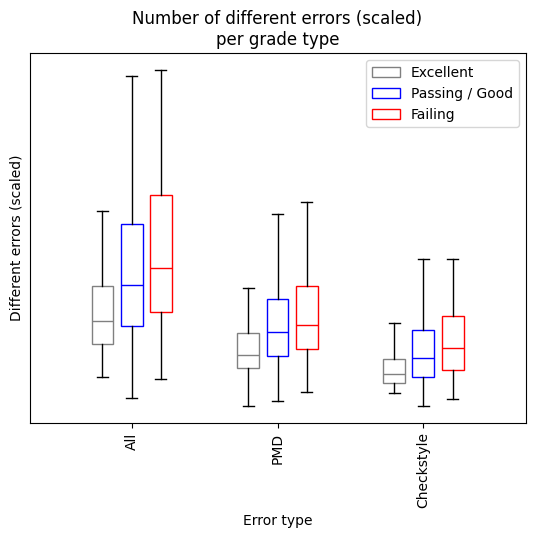

In [12]:
plot_boxes_grade_cats(abt_final, ['errors_count', 'pmd_count', 'checkstyle_count'],
           ['All', 'PMD', 'Checkstyle'],
           "Number of different errors (scaled)\nper grade type",
           'Error type',
           'Different errors (scaled)',
           hide_y = True
           )

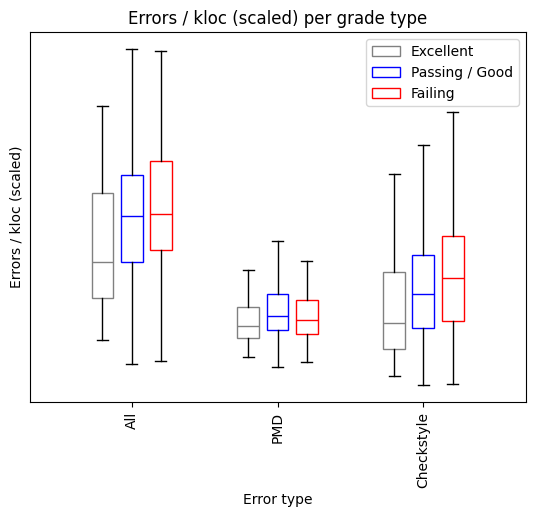

In [13]:
plot_boxes_grade_cats(abt_final, ['errors_total', 'pmd_total', 'checkstyle_total'],
           ['All', 'PMD', 'Checkstyle'],
           "Errors / kloc (scaled) per grade type",
           'Error type',
           'Errors / kloc (scaled)',
           hide_y = True
           )

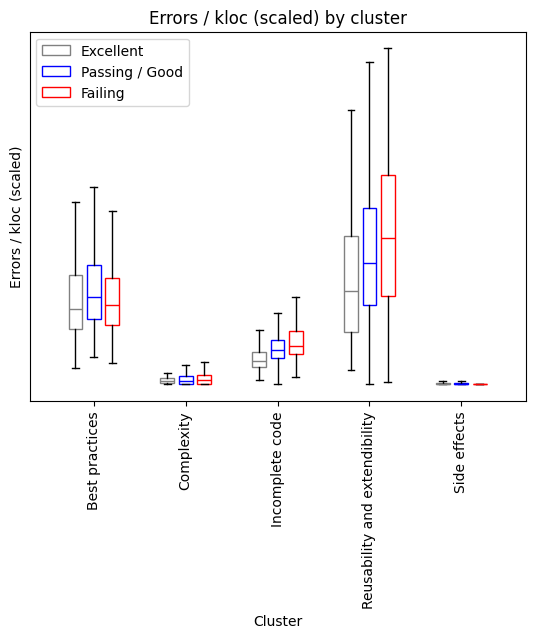

In [14]:
cluster_columns = [x for x in abt_final.columns if x.startswith("cluster_")]
labels = [x.replace('cluster_', '') for x in cluster_columns]


plot_boxes_grade_cats(abt_final,
           cluster_columns,
           labels,
           'Errors / kloc (scaled) by cluster',
           'Cluster',
           'Errors / kloc (scaled)',
           hide_y = True
           )

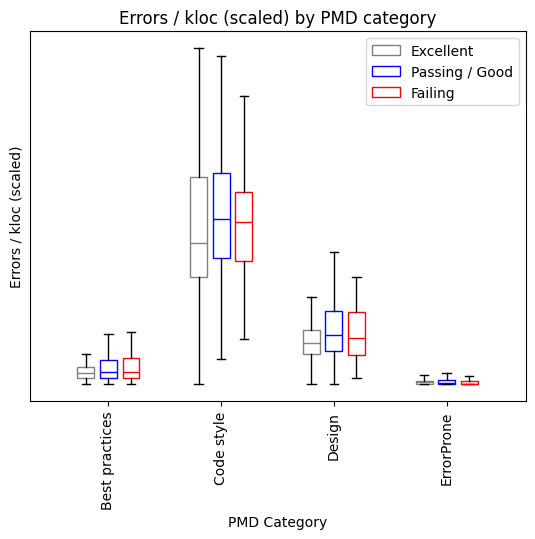

In [15]:
# Individual PMD categories
categories = [x for x in abt_final.columns if x.startswith('pmd_cat_')]
labels = [x.replace('pmd_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'Errors / kloc (scaled) by PMD category',
           'PMD Category',
           'Errors / kloc (scaled)',
           hide_y = True)

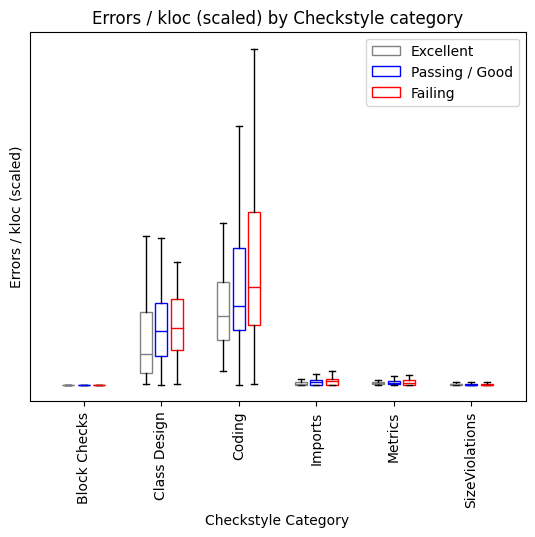

In [16]:
# Individual Checkstyle categories
categories = [x for x in abt_final.columns if x.startswith('checkstyle_cat_')]
labels = [x.replace('checkstyle_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'Errors / kloc (scaled) by Checkstyle category',
           'Checkstyle Category',
           'Errors / kloc (scaled)',
           hide_y = True)

/var/folders/zc/pfyjhy252g1fmlpp0765mxtm0000gn/T/ipykernel_63117/109590687.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']


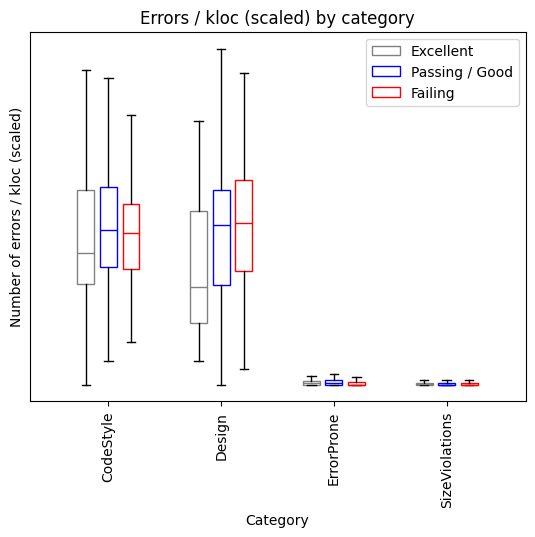

In [17]:
# Categories teachers were questioned on
# Individual PMD categories
abt_cats = abt_final[['grade', 
                      'checkstyle_cat_Class Design',
                      'checkstyle_cat_SizeViolations',
                      'pmd_cat_Design',
                      'pmd_cat_Code style',
                      'pmd_cat_ErrorProne',
                      ]]
abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']
abt_cats = abt_cats.rename({
    'checkstyle_cat_SizeViolations': 'SizeViolations',
    'pmd_cat_Code style' : 'CodeStyle',
    'pmd_cat_ErrorProne' : 'ErrorProne'
}, axis = 1).drop(['checkstyle_cat_Class Design', 'pmd_cat_Design'], axis = 1)

categories = [x for x in abt_cats.columns if x != 'grade']
categories.sort()



plot_boxes_grade_cats(abt_cats,
    categories,
           categories,
           'Errors / kloc (scaled) by category',
           'Category',
           'Number of errors / kloc (scaled)',
           hide_y = True)

# Averages


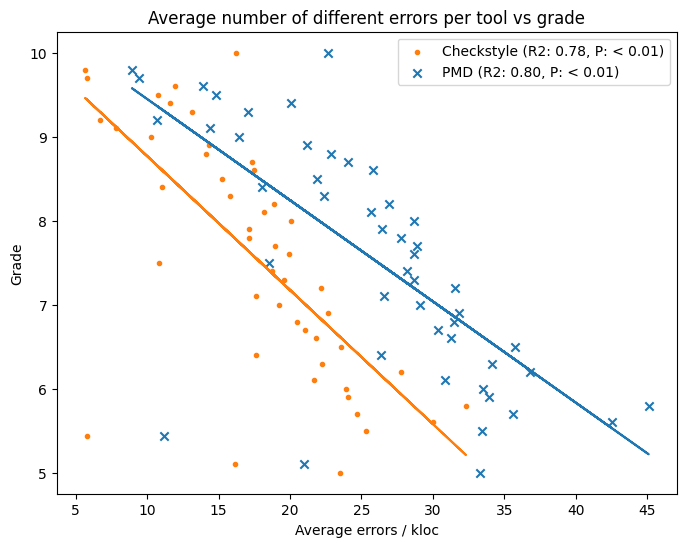

In [18]:

abt_avgs = abt_final.copy()
# Don't bother binning
# abt_binned['grade'] = abt_binned['grade'].apply
#    lambda x : (5 * round((x * 10) / 5)) / 10
# )

#Median does not meaningfully change the results.
abt_avgs = abt_avgs.groupby(by = 'grade').mean().reset_index()

plt.figure(figsize=(8,6))

plt.scatter(abt_avgs['checkstyle_count'], abt_avgs['grade'], marker=".", color="tab:orange")
plt.scatter(abt_avgs['pmd_count'], abt_avgs['grade'], marker='x', color="tab:blue")
# plt.scatter(abt_avgs['errors_count'], abt_avgs['grade'] , marker="o", color="tab:blue")

# Trend line
z = np.polyfit(abt_avgs['checkstyle_count'], abt_avgs['grade'], 1)
p = np.poly1d(z)
plt.plot(abt_avgs['checkstyle_count'], p(abt_avgs['checkstyle_count']),c="tab:orange")
z = np.polyfit(abt_avgs['pmd_count'], abt_avgs['grade'], 1)
p = np.poly1d(z)
plt.plot(abt_avgs['pmd_count'], p(abt_avgs['pmd_count']), c="tab:blue")

# R squared
import statsmodels.api as sm
res = sm.OLS(abt_avgs['grade'], abt_avgs['checkstyle_count']).fit()
r2_cs = res.rsquared
r2_cs_p = "{0:.2f}".format(res.pvalues['checkstyle_count'])
if(res.pvalues['checkstyle_count'] < 0.01):
    r2_cs_p = "< 0.01"

res = sm.OLS(abt_avgs['grade'], abt_avgs['pmd_count']).fit()
r2_pmd = res.rsquared
r2_pmd_p = "{0:.2f}".format(res.pvalues['pmd_count'])
if(res.pvalues['pmd_count'] < 0.01):
    r2_pmd_p = "< 0.01"

plt.title('Average number of different errors per tool vs grade')
plt.xlabel('Average errors / kloc')
plt.ylabel('Grade')
# plt.yticks([])
plt.legend(['Checkstyle (R2: {0:.2f}, P: {1})'.format(r2_cs, r2_cs_p), 'PMD (R2: {0:.2f}, P: {1})'.format(r2_pmd, r2_pmd_p)])
plt.show()



In [19]:


corr_avgs = abt_avgs.corr(method='pearson')
corr_avgs.style.background_gradient(cmap = 'coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.711204,-0.761059,-0.338130,-0.524142,-0.762723,-0.721263,-0.042430,-0.712979,-0.410988,-0.101149,-0.366834,-0.371356,-0.309484,-0.702450,-0.743835,0.188840,-0.665604,-0.689808,-0.715257,-0.534867,0.035573,-0.366834,-0.689521,-0.309484,0.035573
errors_count,-0.711204,1.000000,0.820616,0.336981,0.766138,0.753043,0.782591,0.399974,0.997158,0.407011,-0.286097,0.504187,0.310263,0.399138,0.994864,0.814288,-0.131473,0.817761,0.704598,0.828206,0.736185,0.192068,0.504187,0.807687,0.399138,0.192068
errors_total,-0.761059,0.820616,1.000000,0.576553,0.773664,0.745068,0.948654,0.263604,0.810141,0.586500,-0.082164,0.633754,0.438570,0.476671,0.827342,0.961625,-0.201559,0.854635,0.896243,0.761920,0.767846,0.180464,0.633754,0.875005,0.476671,0.180464
cluster_Best practices,-0.338130,0.336981,0.576553,1.000000,0.178754,0.556087,0.313509,0.465184,0.341587,0.957043,0.496188,0.927686,0.632289,0.221218,0.327774,0.344779,-0.265112,0.491748,0.231106,0.434258,0.202403,-0.014254,0.927686,0.606165,0.221218,-0.014254
cluster_Complexity,-0.524142,0.766138,0.773664,0.178754,1.000000,0.457060,0.822246,0.276448,0.753309,0.199126,-0.391703,0.280872,0.176667,0.525869,0.776515,0.830228,-0.225289,0.644120,0.811762,0.538015,0.933028,0.529922,0.280872,0.617881,0.525869,0.529922
cluster_Incomplete code,-0.762723,0.753043,0.745068,0.556087,0.457060,1.000000,0.578360,0.345769,0.762072,0.710165,0.206175,0.619925,0.722830,0.245676,0.734169,0.623937,-0.165512,0.666056,0.520352,0.762863,0.509187,-0.091019,0.619925,0.784923,0.245676,-0.091019
cluster_Reusability and extendibility,-0.721263,0.782591,0.948654,0.313509,0.822246,0.578360,1.000000,0.094538,0.765966,0.308331,-0.291049,0.392475,0.220836,0.481734,0.797919,0.996277,-0.136342,0.804594,0.969958,0.684164,0.799359,0.231325,0.392475,0.771860,0.481734,0.231325
cluster_Side effects,-0.042430,0.399974,0.263604,0.465184,0.276448,0.345769,0.094538,1.000000,0.401125,0.457451,0.018658,0.560836,0.169521,0.217333,0.394845,0.150899,-0.079912,0.285281,0.054459,0.337501,0.289823,0.232922,0.560836,0.298331,0.217333,0.232922
pmd_count,-0.712979,0.997158,0.810141,0.341587,0.753309,0.762072,0.765966,0.401125,1.000000,0.420616,-0.260301,0.503199,0.334009,0.416206,0.984411,0.797524,-0.157402,0.799593,0.690821,0.816418,0.718265,0.176503,0.503199,0.798024,0.416206,0.176503
pmd_total,-0.410988,0.407011,0.586500,0.957043,0.199126,0.710165,0.308331,0.457451,0.420616,1.000000,0.528997,0.904283,0.797551,0.240940,0.385086,0.341769,-0.282413,0.484904,0.228272,0.476911,0.229529,-0.066573,0.904283,0.644778,0.240940,-0.066573


In [20]:
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_avgs.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_avgs['grade'], abt_avgs[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Metric' : cat,
        'Average value': float(round(abt_avgs[cat].mean() * 100)) / 100,
        'SD' : float(round(abt_avgs[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('../data/all_averages_pearson_vals.xlsx')
pd.DataFrame(pearson_vals)

,Metric,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,43.49,14.57,-0.71,1.469979e-08,0.00000,-0.854770,-0.466536
1,errors_total,536.40,116.06,-0.76,3.419278e-10,0.00000,-0.881556,-0.547458
2,cluster_Best practices,181.55,27.97,-0.34,1.874402e-02,0.01874,-0.626699,0.031991
3,cluster_Complexity,10.65,4.33,-0.52,1.315142e-04,0.00013,-0.746948,-0.195502
4,cluster_Incomplete code,69.96,17.75,-0.76,2.969260e-10,0.00000,-0.882437,-0.550231
5,cluster_Reusability and extendibility,270.86,87.31,-0.72,7.346574e-09,0.00000,-0.860237,-0.482540
6,cluster_Side effects,3.37,1.99,-0.04,7.746148e-01,0.77461,-0.402340,0.328839
7,pmd_count,25.81,8.38,-0.71,1.303364e-08,0.00000,-0.855737,-0.469349
8,pmd_total,225.43,33.88,-0.41,3.710568e-03,0.00371,-0.675495,-0.052769
9,pmd_cat_Best practices,14.42,7.58,-0.10,4.939353e-01,0.49393,-0.450620,0.275205
